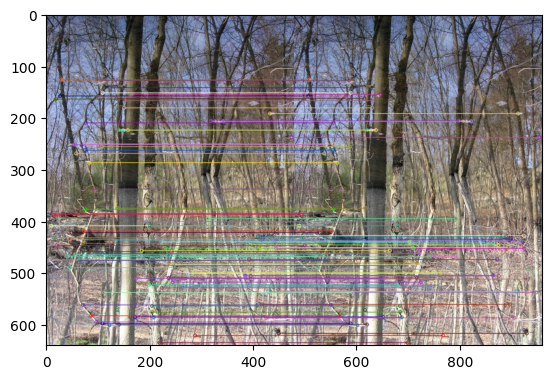

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    """Load and preprocess the image."""
    return cv2.imread(image_path)

def extract_interest_points(image, corner_count=100):
    """Extract interest points using Shi-Tomasi Corner Detector."""
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    corners = cv2.goodFeaturesToTrack(grayscale, corner_count, 0.01, 10)
    return [cv2.KeyPoint(coord[0][0], coord[0][1], 1) for coord in corners]

def generate_patches(image, points, patch_radius=5):
    """Generate patches around each keypoint."""
    patches = []
    for point in points:
        x, y = int(point.pt[0]), int(point.pt[1])
        if (y - patch_radius >= 0 and y + patch_radius < image.shape[0] and
            x - patch_radius >= 0 and x + patch_radius < image.shape[1]):
            patch = image[y-patch_radius:y+patch_radius+1, x-patch_radius:x+patch_radius+1]
            patches.append(patch)
    return patches

def compute_normalized_cross_correlation(patch1, patch2):
    """Compute the Normalized Cross Correlation between two patches."""
    patch1_norm = patch1.astype(np.float32) - np.mean(patch1)
    patch2_norm = patch2.astype(np.float32) - np.mean(patch2)
    numerator = np.sum(patch1_norm * patch2_norm)
    denominator = np.sqrt(np.sum(patch1_norm**2) * np.sum(patch2_norm**2))
    return numerator / denominator if denominator != 0 else 0

def find_feature_matches(patch_set_1, patch_set_2, ncc_threshold=0.9):
    """Find matches between two sets of patches based on NCC."""
    feature_matches = []
    for i, patch1 in enumerate(patch_set_1):
        highest_ncc = 0
        best_match_index = -1
        for j, patch2 in enumerate(patch_set_2):
            ncc_score = compute_normalized_cross_correlation(patch1, patch2)
            if ncc_score > highest_ncc:
                highest_ncc = ncc_score
                best_match_index = j
        if highest_ncc > ncc_threshold:
            feature_matches.append(cv2.DMatch(i, best_match_index, 1 - highest_ncc))
    return feature_matches

# Load images
first_image = preprocess_image('Treescape.jpg')  # Replace with actual image path
second_image = preprocess_image('Treescape.jpg')  # Replace with actual image path

# Extract interest points
interest_points_first = extract_interest_points(first_image)
interest_points_second = extract_interest_points(second_image)

# Generate patches
patches_first_image = generate_patches(first_image, interest_points_first)
patches_second_image = generate_patches(second_image, interest_points_second)

# Find feature matches
matches = find_feature_matches(patches_first_image, patches_second_image)

# Display the matches
matched_image = cv2.drawMatches(first_image, interest_points_first, second_image, interest_points_second, matches, None)
matched_image_converted = cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB)
plt.imshow(matched_image_converted)
plt.show()


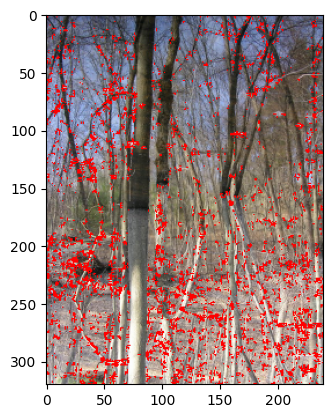

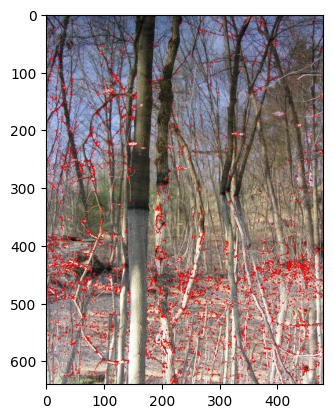

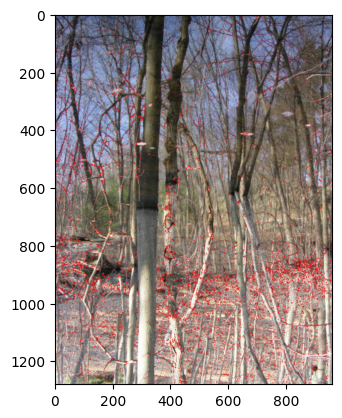

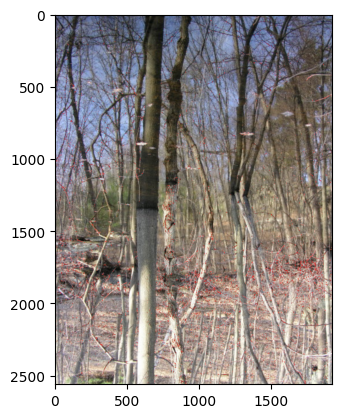

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_corners_with_harris(image):
    """Detect corners in an image using Harris Corner Detector."""
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    detected_corners = cv2.cornerHarris(grayscale_image, 2, 3, 0.04)
    return detected_corners

def highlight_corners_on_image(image, corners):
    """Highlight corners on an image."""
    highlighted_image = np.copy(image)
    threshold = 0.01 * corners.max()
    highlighted_image[corners > threshold] = [0, 0, 255]
    return highlighted_image

def display_image(image):
    """Display an image with matplotlib."""
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_image)
    plt.show()

def process_image_at_scales(image_path, scales):
    """Process and display corners at different scales."""
    base_image = cv2.imread(image_path)
    for scale in scales:
        scaled_image = cv2.resize(base_image, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
        corners = detect_corners_with_harris(scaled_image)
        corner_highlighted_image = highlight_corners_on_image(scaled_image, corners)
        display_image(corner_highlighted_image)

# Image path (replace with actual image path)
image_path = 'Treescape.jpg'

# Different scales for processing
scales_to_process = [0.5, 1, 2, 4]

# Process and display image at different scales
process_image_at_scales(image_path, scales_to_process)


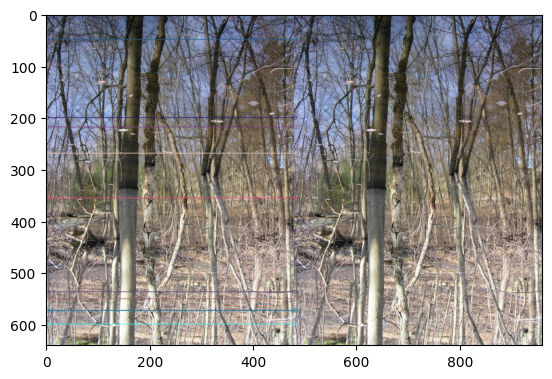

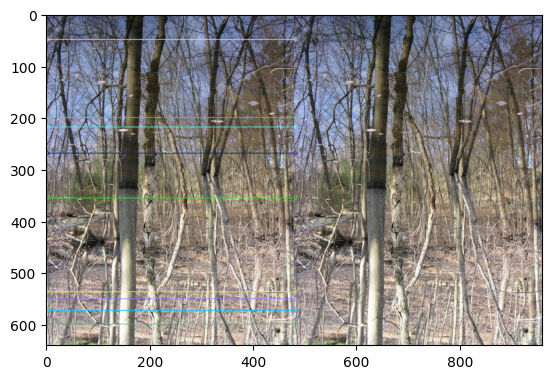

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_ncc(descriptors_a, descriptors_b):
    """Calculate the Normalized Cross-Correlation between sets of descriptors."""
    ncc_result = np.dot(descriptors_a, descriptors_b.T)
    norms_a = np.linalg.norm(descriptors_a, axis=1)
    norms_b = np.linalg.norm(descriptors_b, axis=1)
    ncc_result /= np.outer(norms_a, norms_b)
    return ncc_result

def display_image_rgb(image):
    """Display an image with RGB colors using matplotlib."""
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

def load_and_process_images(image_path1, image_path2):
    """Load two images and process them using SIFT to detect and compute features."""
    image1 = cv2.imread(image_path1)
    image2 = cv2.imread(image_path2)
    sift_detector = cv2.SIFT_create()
    kp1, desc1 = sift_detector.detectAndCompute(image1, None)
    kp2, desc2 = sift_detector.detectAndCompute(image2, None)
    return image1, image2, kp1, kp2, desc1, desc2

def normalize_descriptors(descriptors):
    """Normalize SIFT descriptors."""
    return descriptors / np.linalg.norm(descriptors, axis=1, keepdims=True)

def find_matches_using_ncc(desc1, desc2, threshold=0.75):
    """Find feature matches based on NCC score."""
    matches = []
    for idx, scores in enumerate(calculate_ncc(desc1, desc2)):
        best_match_index = np.argmax(scores)
        if scores[best_match_index] > threshold:
            matches.append(cv2.DMatch(idx, best_match_index, scores[best_match_index]))
    return matches

def match_using_l2_distance(desc1, desc2):
    """Match features using L2 distance."""
    matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    return sorted(matcher.match(desc1, desc2), key=lambda match: match.distance)

def draw_and_show_matches(image1, kp1, image2, kp2, matches, match_type="NCC"):
    """Draw and show matches between two sets of keypoints."""
    img_matches = cv2.drawMatches(image1, kp1, image2, kp2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    display_image_rgb(img_matches)

# Image file paths (replace with actual paths)
file_path1 = 'Treescape.jpg'
file_path2 = 'Treescape.jpg'

# Load images and process them
img1, img2, keypoints1, keypoints2, descriptors1, descriptors2 = load_and_process_images(file_path1, file_path2)

# Normalize descriptors
norm_desc1 = normalize_descriptors(descriptors1)
norm_desc2 = normalize_descriptors(descriptors2)

# Find matches using NCC
ncc_matches = find_matches_using_ncc(norm_desc1, norm_desc2)

# Find matches using L2 distance
l2_distance_matches = match_using_l2_distance(descriptors1, descriptors2)

# Draw and display NCC and L2 matches
draw_and_show_matches(img1, keypoints1, img2, keypoints2, ncc_matches, "NCC")
draw_and_show_matches(img1, keypoints1, img2, keypoints2, l2_distance_matches, "L2")


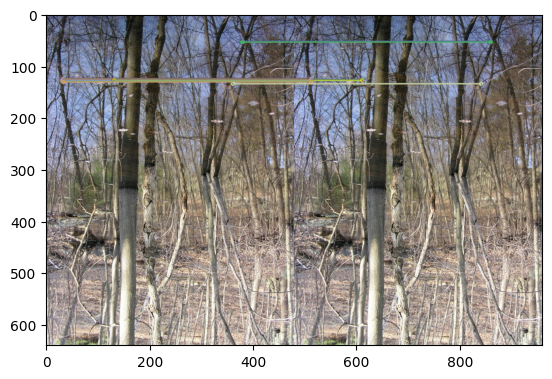

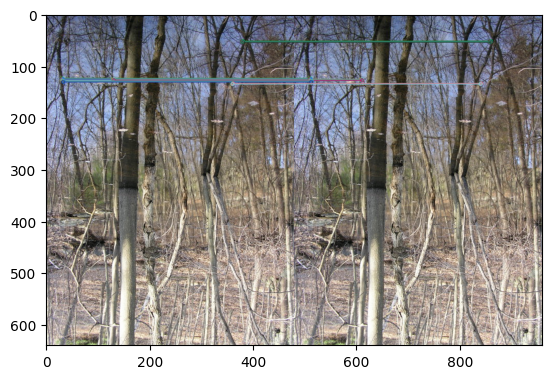

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def find_corners_using_harris(image, block_size=2, aperture=3, harris_k=0.04, thresh=0.1):
    """Detect corners in an image using the Harris Corner Detection method."""
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
    detected_corners = cv2.cornerHarris(gray_image, block_size, aperture, harris_k)
    detected_corners = cv2.dilate(detected_corners, None)
    corner_positions = np.argwhere(detected_corners > thresh * detected_corners.max())
    return [cv2.KeyPoint(float(pos[1]), float(pos[0]), 1) for pos in corner_positions]

def get_feature_descriptors(image, points, patch_radius=5):
    """Extract feature descriptors from the specified keypoints."""
    feature_desc = []
    for point in points:
        x, y = int(point.pt[0]), int(point.pt[1])
        if x - patch_radius < 0 or y - patch_radius < 0 or x + patch_radius > image.shape[1] or y + patch_radius > image.shape[0]:
            continue
        patch = image[y - patch_radius:y + patch_radius + 1, x - patch_radius:x + patch_radius + 1]
        patch = cv2.resize(patch, (2 * patch_radius + 1, 2 * patch_radius + 1))
        feature_desc.append(patch.flatten())
    return np.array(feature_desc, dtype=np.float32)

def normalized_cross_correlation(desc_set_1, desc_set_2):
    """Compute the Normalized Cross-Correlation between two sets of descriptors."""
    ncc_matrix = np.dot(desc_set_1, desc_set_2.T)
    norm_1 = np.linalg.norm(desc_set_1, axis=1)
    norm_2 = np.linalg.norm(desc_set_2, axis=1)
    ncc_matrix /= np.outer(norm_1, norm_2)
    return ncc_matrix

def display_matched_features(image):
    """Display an image with RGB color using matplotlib."""
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

def load_images_and_detect_features(image_path1, image_path2):
    """Load two images and detect features using the Harris Corner Detector."""
    img1 = cv2.imread(image_path1)
    img2 = cv2.imread(image_path2)
    corners_img1 = find_corners_using_harris(img1)
    corners_img2 = find_corners_using_harris(img2)
    desc_img1 = get_feature_descriptors(img1, corners_img1)
    desc_img2 = get_feature_descriptors(img2, corners_img2)
    return img1, img2, corners_img1, corners_img2, desc_img1, desc_img2

# Replace with actual image paths
image_file1 = 'Treescape.jpg'
image_file2 = 'Treescape.jpg'

# Load images and extract features
image1, image2, kp1, kp2, desc1, desc2 = load_images_and_detect_features(image_file1, image_file2)

# Normalize and match descriptors
norm_desc1 = desc1 / np.linalg.norm(desc1, axis=1, keepdims=True)
norm_desc2 = desc2 / np.linalg.norm(desc2, axis=1, keepdims=True)
ncc_result = normalized_cross_correlation(norm_desc1, norm_desc2)

# Find and display matches
ncc_threshold = 0.75
matches_ncc = [cv2.DMatch(i, np.argmax(scores), scores[np.argmax(scores)]) for i, scores in enumerate(ncc_result) if scores[np.argmax(scores)] > ncc_threshold]

# Match using L2 distance
bf_matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches_l2 = sorted(bf_matcher.match(desc1, desc2), key=lambda m: m.distance)

# Draw and show matches
matched_ncc = cv2.drawMatches(image1, kp1, image2, kp2, matches_ncc[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
matched_l2 = cv2.drawMatches(image1, kp1, image2, kp2, matches_l2[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

display_matched_features(matched_ncc)
display_matched_features(matched_l2)
